# 패키지 불러오기

In [1]:
import numpy as np
import pandas as pd
import json
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
import re
import glob
import os

from scipy import stats
from scipy.integrate import trapz

import missingno as msno

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 20, 'max_rows', 20, 'max_colwidth', 10)

In [2]:
# 전처리
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

## 알고리즘(회귀)
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import statsmodels.api as sm

## 데이터 셋 만들기
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer

# 파이프라인
from sklearn.pipeline import Pipeline

## 데이터 평가
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import precision_recall_curve

# 데이터 입력 및 조정

In [4]:
train = pd.read_csv(r'C:\puzzledata\OneDrive - 퍼즐데이터\01_sejin\03_ADP\02_실기\03_연습\5장\bike-sharing-demand\train.csv')
test = pd.read_csv(r'C:\puzzledata\OneDrive - 퍼즐데이터\01_sejin\03_ADP\02_실기\03_연습\5장\bike-sharing-demand\test.csv')

In [5]:
bike_df = pd.concat([train, test], axis=0)

In [6]:
bike_df = bike_df.reset_index(drop=True)

In [7]:
bike_df['datetime'] = pd.to_datetime(bike_df['datetime'])

In [8]:
bike_df['year'] = bike_df['datetime'].dt.year
bike_df['month'] = bike_df['datetime'].dt.month
bike_df['day'] = bike_df['datetime'].dt.day
bike_df['hour'] = bike_df['datetime'].dt.hour

In [9]:
bike_df = bike_df.drop('datetime', axis=1)

In [10]:
train_1 = bike_df[:train.shape[0]]
test_1 = bike_df[:test.shape[0]]

In [11]:
X_features = train_1.drop('count', axis=1)
y_target = train_1[['count']]

# 데이터 확인

## y값 정규성 확인

<AxesSubplot:ylabel='Density'>

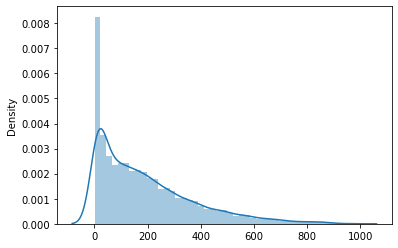

In [12]:
sns.distplot(y_target)

<AxesSubplot:ylabel='Density'>

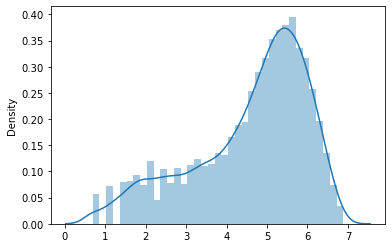

In [13]:
sns.distplot(np.log1p(y_target))

<AxesSubplot:ylabel='Density'>

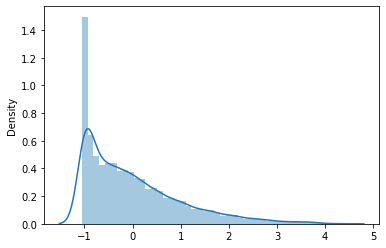

In [14]:
scaler = StandardScaler()
y_target_S = scaler.fit_transform(y_target)
sns.distplot(y_target_S)

In [15]:
y_target_S

array([[-0.9692938 ],
       [-0.83679677],
       [-0.88096245],
       ...,
       [-0.13014594],
       [-0.34545361],
       [-0.57180271]])

<AxesSubplot:ylabel='Density'>

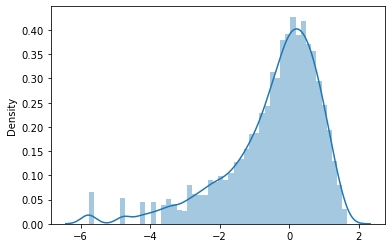

In [16]:
sns.distplot(np.log1p(y_target_S))

## x값 선형성 확인

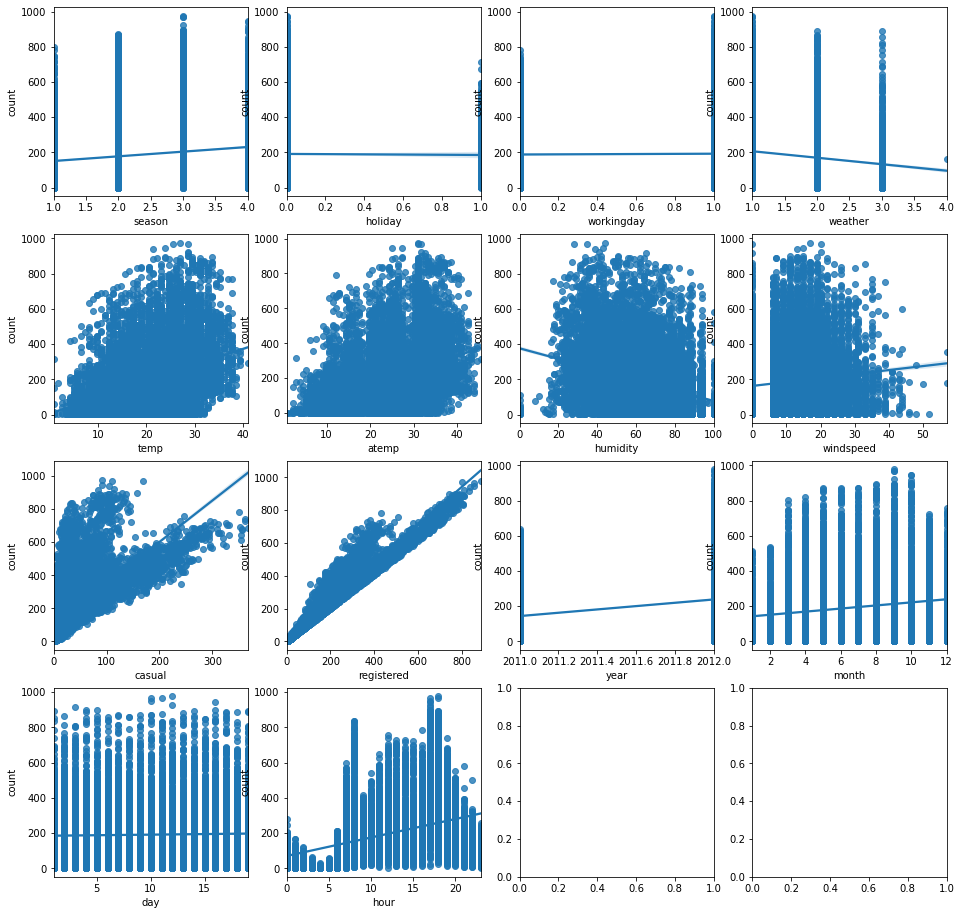

In [17]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,16) , ncols=4 , nrows=4)

features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'year',
       'month', 'day', 'hour']

for i , feature in enumerate(features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature , y='count',data=train_1 , ax=axs[row][col])

# 전처리
* y값을 먼저 정규화하고 로그값을 씌여 정규분표화로 만든다. 그래야 모델학습이 잘 됨
* 다음으로 X값을 정규분포로 만듬

## 컬럼 늘리기

### Polynomial Regression

In [ ]:
# 다항식으로 변환한 단항식 생성, [[0,1],[2,3]]의 2X2 행렬 생성
X = np.arange(4).reshape(2,2)
print('일차 단항식 계수 feature:\n',X )

# degree = 2 인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용하여 변환
poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('변환된 2차 다항식 계수 feature:\n', poly_ftr)

## 데이터 분리

### train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156, stratify=y_target)

print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/y_train.count())
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/y_test.count())

### K-fold(전처리 후 진행해야 함)
- 1,2,3,4 폴드로 한번씩 나눠서 뿌리기 때문에 예측도 같이 돌려야 함

In [ ]:
ridge_reg = Ridge(random_state=156)

# 5개의 폴드 세트로 분리하는 KFold 객체와 폴드 세트별 정확도를 담을 리스트 객체 생성.
kfold = KFold(n_splits=5)
n_iter = 0
cv_mse = []

# KFold객체의 split( ) 호출하면 폴드 별 학습용, 검증용 테스트의 로우 인덱스를 array로 반환  
for train_index, test_index  in kfold.split(X_features):
    # kfold.split( )으로 반환된 인덱스를 이용하여 학습용, 검증용 테스트 데이터 추출
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_target[train_index], y_target[test_index]
    
    #학습 및 예측 
    ridge_reg.fit(X_train , y_train)
    pred = dt_clf.predict(X_test)
    n_iter += 1
    
    # 반복 시 마다 정확도 측정 
    mse = np.round(mean_squared_error(y_test, pred), 4)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mean_squared_error(y_test, pred),
                                                  np.sqrt(mean_squared_error(y_test, pred))))
    print('Variance score : {0:.3f}'.format(r2_score(y_test, ridge_pred)))
    
    print('\n#{0} 교차 검증 정확도 :{1}, 학습 데이터 크기: {2}, 검증 데이터 크기: {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스:{1}'.format(n_iter,test_index))
    
    cv_mse.append(mse)
    
# 개별 iteration별 정확도를 합하여 평균 정확도 계산 
print('\n## 평균 검증 정확도:', np.mean(cv_mse)) 

### Stratified K-fold(전처리 후 진행해야 함)

In [ ]:
ridge_reg = Ridge(random_state=156)

# 5개의 폴드 세트로 분리하는 KFold 객체와 폴드 세트별 정확도를 담을 리스트 객체 생성.
skfold = StratifiedKFold(n_splits=3)
n_iter = 0
cv_mse = []

# KFold객체의 split( ) 호출하면 폴드 별 학습용, 검증용 테스트의 로우 인덱스를 array로 반환  
for train_index, test_index  in skfold.split(X_features, y_target):
    # kfold.split( )으로 반환된 인덱스를 이용하여 학습용, 검증용 테스트 데이터 추출
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_target[train_index], y_target[test_index]
    
    #학습 및 예측 
    ridge_reg.fit(X_train , y_train)
    pred = dt_clf.predict(X_test)
    n_iter += 1
    
    # 반복 시 마다 정확도 측정 
    mse = np.round(mean_squared_error(y_test, pred), 4)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mean_squared_error(y_test, pred),
                                                  np.sqrt(mean_squared_error(y_test, pred))))
    print('Variance score : {0:.3f}'.format(r2_score(y_test, ridge_pred)))
    
    print('\n#{0} 교차 검증 정확도 :{1}, 학습 데이터 크기: {2}, 검증 데이터 크기: {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스:{1}'.format(n_iter,test_index))
    
    cv_mse.append(mse)
    
# 개별 iteration별 정확도를 합하여 평균 정확도 계산 
print('\n## 평균 검증 정확도:', np.mean(cv_mse)) 

## 범주 데이터 수치화

### get_dummies

### Label Incoding

### one-hot Incoding

## Scaler

### StandardScaler

In [ ]:
# X_features scaling
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_S = pd.DataFrame(scaler.transform(X_train), 
                                       index=X_train.index, columns=X_train.columns)
X_test_S = pd.DataFrame(scaler.transform(X_test), 
                           index=X_test.index, columns=X_test.columns)
display(X_test_S.describe().T)

# y_target scaling
scaler = StandardScaler()
scaler = scaler.fit(y_train)
y_train_S = pd.DataFrame(scaler.transform(y_train), 
                                       index=y_train.index, columns=y_train.columns)
y_test_S = pd.DataFrame(scaler.transform(y_test), 
                           index=y_test.index, columns=y_test.columns)
display(y_test_S.describe().T)

### MinMaxScaler

In [ ]:
# X_features scaling
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
X_train_S = pd.DataFrame(scaler.transform(X_train), 
                                       index=X_train.index, columns=X_train.columns)
X_test_S = pd.DataFrame(scaler.transform(X_test), 
                           index=X_test.index, columns=X_test.columns)
display(X_test_S.describe().T)

# y_target scaling
scaler = MinMaxScaler()
scaler = scaler.fit(y_train)
y_train_S = pd.DataFrame(scaler.transform(y_train), 
                                       index=y_train.index, columns=y_train.columns)
y_test_S = pd.DataFrame(scaler.transform(y_test), 
                           index=y_test.index, columns=y_test.columns)
display(y_test_S.describe().T)

### Normalizer

In [ ]:
# X_features scaling
scaler = Normalizer()
scaler = scaler.fit(X_train)
X_train_S = pd.DataFrame(scaler.transform(X_train), 
                                       index=X_train.index, columns=X_train.columns)
X_test_S = pd.DataFrame(scaler.transform(X_test), 
                           index=X_test.index, columns=X_test.columns)
display(X_test_S.describe().T)

# y_target scaling
scaler = Normalizer()
scaler = scaler.fit(y_train)
y_train_S = pd.DataFrame(scaler.transform(y_train), 
                                       index=y_train.index, columns=y_train.columns)
y_test_S = pd.DataFrame(scaler.transform(y_test), 
                           index=y_test.index, columns=y_test.columns)
display(y_test_S.describe().T)

### Log1p

In [ ]:
# X_features scaling
X_train_S = pd.DataFrame(np.log1p(X_train), index=X_train.index, columns=X_train.columns)
X_test_S = pd.DataFrame(np.log1p(X_test), index=X_test.index, columns=X_test.columns)
display(X_test_S.describe().T)

# y_target scaling
y_train_S = pd.DataFrame(np.log1p(y_train), index=X_train.index, columns=y_train.columns)
y_test_S = pd.DataFrame(np.log1p(y_test), index=y_test.index, columns=y_test.columns)
display(y_test_S.describe().T)

## 다중공선성제거

### VIF

#### 상관도 확인

In [ ]:
corr = X_features.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True, fmt='.1g')

In [ ]:
# correlation from features
raw_df.corr().loc[X_colname, X_colname].style.background_gradient().set_precision(2).set_properties(**{'font-size': '11pt'})

In [ ]:
corr = X_features.corr().loc[:, ['count']]

In [ ]:
corr = X_features.corr().loc[:, ['count']].style.background_gradient().set_precision(2).set_properties(**{'font-size': '11pt'})

In [ ]:
for col in raw_df.describe().columns:
    target = raw_df[col]
    figure, axes = plt.subplots(2,1,figsize=(16,10))
    sm.graphics.tsa.plot_acf(target, lags=100, use_vlines=True, ax=axes[0], title=col)
    sm.graphics.tsa.plot_pacf(target, lags=100, use_vlines=True, ax=axes[1], title=col)

In [ ]:
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_train_S.values, i)
                     for i in range(X_train_S.shape[1])]
vif['Feature'] = X_train_S.columns
vif.sort_values(by='VIF_Factor', ascending=True)

In [ ]:
# extract effective features using variance inflation factor
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_train_S.values, i) 
                     for i in range(X_train_S.shape[1])]
vif['Feature'] = X_train_S.columns
vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:10].values

#### 독립변수 일부 반영

In [ ]:
### Functionalize
### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif
# X_colname_vif = feature_engineer

In [ ]:
feature_engineering_XbyVIF(X_train_S, 10)

### PCA

In [23]:
pca = PCA(n_components=3)

#fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환
pca.fit(X_features)
X_features_pca = pca.transform(X_features)

print('PCA Component별 변동성:', pca.explained_variance_ratio_)

PCA Component별 변동성: [0.90625295 0.07186388 0.01272779]


### LDA

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
# fit()호출 시 target값 입력
lda.fit(X_features, y_target)
X_features_lda = lda.transform(X_features)
print(iris_lda.shape)

In [ ]:
lda_columns=['lda_component_1','lda_component_2']
X_lda_df = pd.DataFrame(X_features_lda,columns=lda_columns)
X_lda_df['target']=y_target

### SVD(미완)

### Truncated SVD(미완)

### NMF(미완)

# 기본 통계

In [ ]:
from scipy import stats

## 단일표본 t-test

In [ ]:
# 1-sample
stats.ttest_1samp(raw_df['col'], 4500)

# 검정통계량 구하는 방법, p-value 구하는 방법 알아야 함

## 독립표본 t-test

In [ ]:
#  https://www.youtube.com/watch?v=CYp4D4_20cc&list=PLCt8K88AxcKPucYITFaLshFeCIp8F9IGk&index=7
# 여기서는 range 컬럼을 독립변수로 삼음
# col 컬럼과 평균차이가 있다고 볼 수 있는가?
close = raw_df[raw_df['range'] == 1]
range1 = np.array(close['col'])
far = raw_df[raw_df['range'] == 2]
range2 = np.array(far['col'])

# 등분산 검정
# p-value가 0.05보다 커야됨(기각하지 못하므로 등분산이 됨)
stats.bartlett(range1, range2)

In [ ]:
# independant-sample
# equal_var는 등분산 여부
stats.ttest_ind(range1, range2, equal_var=True)

## 대응표본 t-test

In [ ]:
# paired-sample
stats.ttest_rel(raw_df['col_1'], raw_df['col_2'])

## 상관계수

In [ ]:
raw_df_corr = raw_df[['col_1', 'col_2', 'col_3']]

# correlation-coefficient
raw_df_corr.corr(method='pearson')

## 편상관계수

In [ ]:
# partial-correlation-coefficient
# pip install pingouin 로 설치 후 사용가능
from pingouin import parial_corr
partial_corr(data=raw_df, x='stat', y='HP', covar='attack')

# 통합 예측 및 평가

## 로그값 취했을 경우 풀기 전환

In [ ]:
# 로그를 취했을 경우 학습 후 로그 풀기
y_test = np.expm1(y_test)
ridge_pred = np.expm1(ridge_pred)

# 평가
evaluate_regr(y_test, ridge_pred)

## 평가 함수

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 언더플로우 영향으로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def msle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    msle = np.mean(squared_error)
    return msle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    rmse = np.sqrt(mean_squared_error(y, pred))
    return rmse

def msle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    msle = np.mean(squared_error)
    return msle

def mape(y, pred):
    mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
    return mape

# MAE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    msle_val = msle(y, pred)
    mae_val = mean_absolute_error(y,pred)
    mse_val = mean_squared_error(y, pred)
    mape_val = mape(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}'.format(rmsle_val, rmse_val))
    print('MSLE: {0:.3f}, MSE: {1:.3F}, MAE: {2:.3F}, MAPE: {2:.4F}'.format(msle_val, mse_val,
                                                                            mae_val, mape_val))
    print('-------------------------------------------------------------------------------------------------\n')

In [45]:
# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

In [55]:
def get_model_cv_prediction(model, X_features, y_target):
    neg_mse_scores = cross_val_score(model, X_features, y_target, scoring="neg_mean_squared_error",
                                     cv = 5, n_jobs=-1)
    # MAE
    mae_scores  = np.sqrt(abs(neg_mse_scores))
    avg_mae = np.mean(mae_scores)
    # MSE
    mse_scores  = (-1 * neg_mse_scores)
    avg_mse = np.mean(mse_scores)
    # MAPE
    mape_scores  = np.sqrt(abs(neg_mse_scores))*100
    avg_mape = np.mean(mape_scores)
    # RMSE
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    
    print('##### 5 교차 검증 ',model.__class__.__name__ , ' #####\n')
    print(' - MAE :\n {0} '.format(mae_scores))
    print(' - 평균 MAE :\n {0:.3f} '.format(avg_mae))
    print(' - MSE :\n {0} '.format(mse_scores))
    print(' - 평균 MSE :\n {0:.3f} '.format(avg_mse))
    print(' - MAPE :\n {0} '.format(mape_scores))
    print(' - 평균 MAPE :\n {0:.3f} '.format(avg_mape))
    print(' - RMSE :\n {0} '.format(rmse_scores))
    print(' - 평균 RMSE :\n {0:.3f} '.format(avg_rmse))
    print('-------------------------------------------------------------------------------------------------\n')

## 교차 검증 없이 예측 및 평가

In [ ]:
# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=0.1)
lasso_reg = Lasso(alpha=0.1)
ela_reg = ElasticNet(alpha=0.01, l1_ratio=0.7)
dt_reg = DecisionTreeRegressor(max_depth=3, min_samples_split=3)
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

model_list = [lr_reg, ridge_reg, lasso_reg, ela_reg, dt_reg, rf_reg, gbm_reg, xgb_reg, lgbm_reg]

for model in model_list:
    get_model_predict(model, X_train, X_test, y_train, y_test,is_expm1=False)

## 교차 검증을 포함한 예측 및 평가

In [54]:
# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=0.01)
lasso_reg = Lasso(alpha=0.01)
ela_reg = ElasticNet(alpha=0.01, l1_ratio=0.7)
dt_reg = DecisionTreeRegressor(max_depth=3, min_samples_split=3)
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

model_list = [lr_reg, ridge_reg, lasso_reg, ela_reg, dt_reg, rf_reg, gbm_reg, xgb_reg, lgbm_reg]

for model in model_list:
    get_model_cv_prediction(model, X_features, y_target)

##### 5 교차 검증  LinearRegression  #####

 - MAE :
 [2.37458693e-13 8.46742511e-13 2.62454604e-13 2.28787807e-13
 3.28225762e-13] 
 - 평균 MAE :
 0.000 
 - MSE :
 [5.63866309e-26 7.16972879e-25 6.88824189e-26 5.23438607e-26
 1.07732151e-25] 
 - 평균 MSE :
 0.000 
 - MAPE :
 [2.37458693e-11 8.46742511e-11 2.62454604e-11 2.28787807e-11
 3.28225762e-11] 
 - 평균 MSE :
 0.000 
 - RMSE :
 [2.37458693e-13 8.46742511e-13 2.62454604e-13 2.28787807e-13
 3.28225762e-13] 
 - 평균 RMSE :
 0.000 
-------------------------------------------------------------------------------------------------

##### 5 교차 검증  Ridge  #####

 - MAE :
 [2.49649166e-08 3.02103597e-08 2.28364176e-08 5.92651781e-08
 3.85377963e-08] 
 - 평균 MAE :
 0.000 
 - MSE :
 [6.23247063e-16 9.12665831e-16 5.21501969e-16 3.51236134e-15
 1.48516175e-15] 
 - 평균 MSE :
 0.000 
 - MAPE :
 [2.49649166e-06 3.02103597e-06 2.28364176e-06 5.92651781e-06
 3.85377963e-06] 
 - 평균 MSE :
 0.000 
 - RMSE :
 [2.49649166e-08 3.02103597e-08 2.28364176e-08 5.926517

# 개별 예측 및 평가

## 평가 함수

In [65]:
# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_no_machin_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
    # 회귀계수 추출
    coeff = pd.Series(data=model.coef_ , index=X_features.columns)
    return coeff

## LinearRegression

In [71]:
# Linear Regression OLS로 학습/예측/평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train ,y_train)
lr_pred = lr_reg.predict(X_test)

mse = mean_squared_error(y_test, lr_pred)
rmse = np.sqrt(mse)

# # 평가
# evaluate_regr(y_test, lr_pred)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, lr_pred)))

print('절편 값:',lr_reg.intercept_)
print('회귀 계수값:', np.round(lr_reg.coef_, 1))

MSE : 0.000 , RMSE : 0.000
Variance score : 1.000
절편 값: [8.38440428e-12]
회귀 계수값: [[-0.  0. -0. -0. -0.  0.  0.  0.  1.  1. -0.  0.  0. -0.]]


In [72]:
coeff_df = pd.DataFrame()

params = [0.1, 0.3, 0.5]

for param in params:
    lasso_reg = Lasso(alpha=param)

    neg_mse_scores = cross_val_score(lasso_reg, X_features, y_target, scoring="neg_mean_squared_error",
                                     cv = 5)
    # 평가
    avg_mse = np.mean(-1 * neg_mse_scores)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 MSE: {1:.3f}, 평균 RMSE: {2:.3f}'\
          .format(param, avg_mse, avg_rmse))
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

    lasso_reg.fit(X_features , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
    coeff = pd.Series(data=lasso_reg.coef_ , index=X_features.columns )
    colname='alpha:'+str(param)
    coeff_df[colname] = coeff
    
coeff_df

alpha 0.1일 때 5 폴드 세트의 평균 MSE: 0.000, 평균 RMSE: 0.003
alpha 0.3일 때 5 폴드 세트의 평균 MSE: 0.000, 평균 RMSE: 0.007
alpha 0.5일 때 5 폴드 세트의 평균 MSE: 0.000, 평균 RMSE: 0.011


,alpha:0.1,alpha:0.3,alpha:0.5
season,0.000000,0.000000,0.000000
holiday,0.000000,0.000000,0.000000
workingday,-0.000000,-0.000000,-0.000000
weather,-0.000000,-0.000000,-0.000000
temp,0.000000,0.000000,0.000000
atemp,0.000000,0.000000,0.000000
humidity,-0.000000,-0.000000,-0.000000
windspeed,0.000000,0.000000,0.000000
casual,0.999934,0.999849,0.999746
registered,1.000007,1.000012,1.000020


## Ridge

In [74]:
X_features

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,7.0,329.0,2012,12,19,19
10882,4,0,1,1,14.76,17.425,57,15.0013,10.0,231.0,2012,12,19,20
10883,4,0,1,1,13.94,15.910,61,15.0013,4.0,164.0,2012,12,19,21
10884,4,0,1,1,13.94,17.425,61,6.0032,12.0,117.0,2012,12,19,22


In [ ]:
pd.Series(data=ridge_reg.coef_ , index=X_features.columns)

In [81]:
ridge_reg.coef_.flatten()

array([ 6.75709331e-09, -1.24140755e-07, -4.13714639e-07,  2.65868831e-08,
        1.46954915e-08,  1.18938002e-08, -7.66494107e-09, -3.50079344e-11,
        9.99999989e-01,  1.00000000e+00,  7.77897908e-08,  1.51707191e-09,
        6.31111496e-10,  9.67323697e-09])

In [83]:
coeff_df = pd.DataFrame()

# 학습
ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)

coeff = pd.Series(data=ridge_reg.coef_.flatten() , index=X_features.columns)
coeff_df['coefficient'] = coeff
coeff_df = coeff_df.sort_values('coefficient', ascending=False)
coeff_df

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, ridge_pred)))

print('절편 값:',ridge_reg.intercept_)
print('회귀 계수값:', np.round(ridge_reg.coef_, 1))

MSE : 0.000 , RMSE : 0.000
Variance score : 1.000
절편 값: [-0.00015615]
회귀 계수값: [[ 0. -0. -0.  0.  0.  0. -0. -0.  1.  1.  0.  0.  0.  0.]]


###  make_scorer

In [85]:
coeff_df = pd.DataFrame()

params = [0.1, 0.3, 0.5]

for param in params:
    ridge_reg = Ridge(alpha=param)

    neg_mse_scores = cross_val_score(ridge_reg, X_features, y_target, scoring=make_scorer(mape),
                                     cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 개별 MSE scores: ', np.round(-1 * neg_mse_scores, 2))
    print('alpha {0}일 때 세트의 평균 MSE: {1:.3f} '.format(param, avg_mse))
    print('alpha {0}일 때 개별 RMSE scores: ', np.round(-1 * neg_mse_scores, 2))
    print('alpha {0}일 때 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

    ridge_reg.fit(X_features , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
    coeff = pd.Series(data=ridge_reg.coef_.flatten() , index=X_features.columns )
    colname='alpha:'+str(param)
    coeff_df[colname] = coeff
    
coeff_df

alpha {0}일 때 개별 MSE scores:  [nan nan nan nan nan]
alpha 0.1일 때 세트의 평균 MSE: 0.000 
alpha {0}일 때 개별 RMSE scores:  [nan nan nan nan nan]
alpha 0.1일 때 세트의 평균 RMSE: nan 
alpha {0}일 때 개별 MSE scores:  [nan nan nan nan nan]
alpha 0.3일 때 세트의 평균 MSE: 0.000 
alpha {0}일 때 개별 RMSE scores:  [nan nan nan nan nan]
alpha 0.3일 때 세트의 평균 RMSE: nan 
alpha {0}일 때 개별 MSE scores:  [nan nan nan nan nan]
alpha 0.5일 때 세트의 평균 MSE: 0.000 
alpha {0}일 때 개별 RMSE scores:  [nan nan nan nan nan]
alpha 0.5일 때 세트의 평균 RMSE: nan 


,alpha:0.1,alpha:0.3,alpha:0.5
season,4.0991...,1.2278...,2.0432...
holiday,-9.3614...,-2.8058...,-4.6719...
workingday,-2.7809...,-8.3416...,-1.3900...
weather,1.4286...,4.2852...,7.1410...
temp,9.5065...,2.8516...,4.7523...
atemp,8.4837...,2.5452...,4.2422...
humidity,-5.2265...,-1.5679...,-2.6131...
windspeed,3.4514...,1.0353...,1.7254...
casual,1.0000...,1.0000...,1.0000...
registered,1.0000...,1.0000...,1.0000...


### neg_mean_squared_error

In [88]:
coeff_df = pd.DataFrame()

params = [0.1, 0.3, 0.5]

for param in params:
    ridge_reg = Ridge(alpha=param)

    neg_mse_scores = cross_val_score(ridge_reg, X_features, y_target, scoring="neg_mean_squared_error",
                                     cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 개별 MSE scores: ', np.round(-1 * neg_mse_scores, 2))
    print('alpha {0}일 때 세트의 평균 MSE: {1:.3f} '.format(param, avg_mse))
    print('alpha {0}일 때 개별 RMSE scores: ', np.round(-1 * neg_mse_scores, 2))
    print('alpha {0}일 때 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

    ridge_reg.fit(X_features , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
    coeff = pd.Series(data=ridge_reg.coef_ , index=X_features.columns )
    colname='alpha:'+str(param)
    coeff_df[colname] = coeff
    
coeff_df

alpha {0}일 때 개별 MSE scores:  [0. 0. 0. 0. 0.]
alpha 0.1일 때 세트의 평균 RMSE: 0.000 
alpha {0}일 때 개별 RMSE scores:  [0. 0. 0. 0. 0.]
alpha 0.1일 때 세트의 평균 RMSE: 0.000 
alpha {0}일 때 개별 MSE scores:  [0. 0. 0. 0. 0.]
alpha 0.3일 때 세트의 평균 RMSE: 0.000 
alpha {0}일 때 개별 RMSE scores:  [0. 0. 0. 0. 0.]
alpha 0.3일 때 세트의 평균 RMSE: 0.000 
alpha {0}일 때 개별 MSE scores:  [0. 0. 0. 0. 0.]
alpha 0.5일 때 세트의 평균 RMSE: 0.000 
alpha {0}일 때 개별 RMSE scores:  [0. 0. 0. 0. 0.]
alpha 0.5일 때 세트의 평균 RMSE: 0.000 


,alpha:0.1,alpha:0.3,alpha:0.5
season,4.0991...,1.2278...,2.0432...
holiday,-9.3614...,-2.8058...,-4.6719...
workingday,-2.7809...,-8.3416...,-1.3900...
weather,1.4286...,4.2852...,7.1410...
temp,9.5065...,2.8516...,4.7523...
atemp,8.4837...,2.5452...,4.2422...
humidity,-5.2265...,-1.5679...,-2.6131...
windspeed,3.4514...,1.0353...,1.7254...
casual,1.0000...,1.0000...,1.0000...
registered,1.0000...,1.0000...,1.0000...


In [ ]:
# cross_val_score( )로 5 Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시  RMSE 구함. 
neg_mse_scores = cross_val_score(lr, X_features, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수 
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

## Lasso(수정)

In [86]:
coeff_df = pd.DataFrame()

params = [0.1, 0.3, 0.5]

for param in params:
    lasso_reg = Lasso(alpha=param)

    neg_mse_scores = cross_val_score(lasso_reg, X_features, y_target, scoring="neg_mean_squared_error",
                                     cv = 5)
    # 평가
    avg_mse = np.mean(-1 * neg_mse_scores)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 MSE: {1:.3f}, 평균 RMSE: {2:.3f}'\
          .format(param, avg_mse, avg_rmse))
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

    lasso_reg.fit(X_features , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
    coeff = pd.Series(data=lasso_reg.coef_ , index=X_features.columns )
    colname='alpha:'+str(param)
    coeff_df[colname] = coeff
    
coeff_df

alpha 0.1일 때 5 폴드 세트의 평균 MSE: 0.000, 평균 RMSE: 0.003
alpha 0.3일 때 5 폴드 세트의 평균 MSE: 0.000, 평균 RMSE: 0.007
alpha 0.5일 때 5 폴드 세트의 평균 MSE: 0.000, 평균 RMSE: 0.011


,alpha:0.1,alpha:0.3,alpha:0.5
season,0.000000,0.000000,0.000000
holiday,0.000000,0.000000,0.000000
workingday,-0.000000,-0.000000,-0.000000
weather,-0.000000,-0.000000,-0.000000
temp,0.000000,0.000000,0.000000
atemp,0.000000,0.000000,0.000000
humidity,-0.000000,-0.000000,-0.000000
windspeed,0.000000,0.000000,0.000000
casual,0.999934,0.999849,0.999746
registered,1.000007,1.000012,1.000020


## ElasticNet

In [ ]:
coeff_df = pd.DataFrame()

params = [0.1, 0.3, 0.5]

for param in params:
    en_reg = ElasticNet(alpha=param, l1_ratio=0.7)

    neg_mse_scores = cross_val_score(en_reg, X_features, y_target, scoring="neg_mean_squared_error",
                                     cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

    en_reg.fit(X_features , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
    coeff = pd.Series(data=en_reg.coef_ , index=X_features.columns )
    colname='alpha:'+str(param)
    coeff_df[colname] = coeff
    
coeff_df

## DecisionTreeRegressor

### GridSearchCV

In [116]:
max_depth = [3, None]
max_features = [0.1, 0.2, 0.5, 0.8]
min_samples_split = [2, 10]
min_samples_leaf = [2, 10]

hyperparams = {'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

gd=GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "neg_mean_squared_error", n_jobs=-1)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 145 out of 160 | elapsed:    4.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.1s finished


ValueError: too many values to unpack (expected 4)

In [ ]:
coeff_df = pd.DataFrame()

params = [3,2]

for param in params:
    ridge_reg = DecisionTreeRegressor(max_depth = param)

    neg_mse_scores = cross_val_score(ridge_reg, X_features, y_target, scoring="neg_mean_squared_error",
                                     cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 세트의 평균 MSE: {1:.3f} '.format(param, avg_rmse))
    print('개별 MSE scores:',np.round(-1 * neg_mse_scores, 2))
    print('alpha {0}일 때 개별 RMSE scores: '.format(param, np.round(-1 * neg_mse_scores, 2))
    print('alpha {0}일 때 세트의 평균 RMSE: {1}'.format(param, avg_rmse))
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

    ridge_reg.fit(X_features , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
    coeff = pd.Series(data=ridge_reg.coef_ , index=X_features.columns )
    colname='alpha:'+str(param)
    coeff_df[colname] = coeff
    
coeff_df

## RandomForestRegressor

## GradientBoostingRegressor

## XGBRegressor

## LGBMRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgbm_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgbm_reg]
for model in models:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)
    get_model_cv_prediction(model, X_data, y_target)